# Introduction

In this project, I ventured into the realm of book recommendation systems using an extensive Kaggle dataset. This dataset offers a diverse collection of user-book interactions ripe for exploration. I aimed to craft an advanced recommendation system by harnessing user ratings, book details, and interactions. By combining data mining techniques and content-based methods, my goal was to create a robust system delivering tailored book suggestions, providing insights into user preferences and offering practical enhancements to the literary experience.

# Data Collection

The dataset was sourced from Kaggle.com and is referenced in the project's conclusion under the "References" section for access.

Connecting colab to Drive File

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support

Reading the datasets

In [ ]:
book = pd.read_csv('/content/drive/MyDrive/DM Proj/Books.csv')
ratings = pd.read_csv('/content/drive/MyDrive/Ratings.csv')
users = pd.read_csv('/content/drive/MyDrive/Users.csv')

Merging the datasets and saving them in a seperate csv file

In [ ]:
users_rating = ratings.merge(users, left_on = 'User-ID', right_on = 'User-ID')
book_dataset = book.merge(users_rating, left_on = 'ISBN', right_on = 'ISBN')
book_dataset.reset_index(drop=True, inplace = True)

book_dataset.to_csv('/content/drive/MyDrive/DM Proj/book_dataset.csv')

In [2]:
book = pd.read_csv('/content/drive/MyDrive/DM Proj/book_dataset.csv')

<ipython-input-2-66865ee044d6>:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  book = pd.read_csv('/content/drive/MyDrive/DM Proj/book_dataset.csv')


# Data Exploration

Conducting an analysis of data types and assessing the dataset's size.

Subsequently, scrutinizing for instances of missing values and duplicate entries within the dataset.

In [3]:
print(book.dtypes)
print(book.shape)

Unnamed: 0               int64
ISBN                    object
Book-Title              object
Book-Author             object
Year-Of-Publication     object
Publisher               object
Image-URL-S             object
Image-URL-M             object
Image-URL-L             object
User-ID                  int64
Book-Rating              int64
Location                object
Age                    float64
dtype: object
(1031136, 13)


In [4]:
null = book.isnull().sum()
print("Number of null values:", null)
print(book.shape)

Number of null values: Unnamed: 0                  0
ISBN                        0
Book-Title                  0
Book-Author                 1
Year-Of-Publication         0
Publisher                   2
Image-URL-S                 0
Image-URL-M                 0
Image-URL-L                 4
User-ID                     0
Book-Rating                 0
Location                    0
Age                    277835
dtype: int64
(1031136, 13)


In [5]:
for column in book.columns:
    num_duplicates = book.duplicated(subset=column).sum()
    print(f"'{column}': {num_duplicates}")

'Unnamed: 0': 0
'ISBN': 760985
'Book-Title': 790065
'Book-Author': 929547
'Year-Of-Publication': 1030934
'Publisher': 1014406
'Image-URL-S': 761294
'Image-URL-M': 761294
'Image-URL-L': 761296
'User-ID': 939030
'Book-Rating': 1031125
'Location': 1008656
'Age': 1030994


Isolating numerical columns from the dataset and transforming the DataFrame into a long-form structure suitable for FacetGrid visualization. Subsequently, individual histograms for each numerical column are plotted within the FacetGrid.

The visual representations illustrate considerable bias and imbalance within the distributions of both Age and Rating. Notably, the Age distribution portrays outliers prominently skewed towards the lower end of the scale.

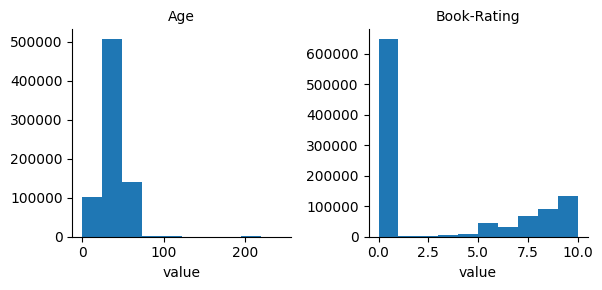

In [6]:
numerical_columns = book[['Age', 'Book-Rating']]

melted = pd.melt(numerical_columns)
g = sns.FacetGrid(melted, col="variable", col_wrap=4, sharex=False, sharey=False)
g.map(plt.hist, "value")

g.set_titles("{col_name}")
plt.show()

The User IDs exhibit a significant bias, with approximately 90% of the entries within this column being duplicates. This observation suggests a scenario where a limited number of individuals contribute to the majority of the dataset, indicating a skewed distribution in user engagement or activity.

In [7]:
val_count = book['User-ID'].value_counts()
print(val_count)

book['User-ID'].nunique()

11676     11144
198711     6456
153662     5814
98391      5779
35859      5646
          ...  
51911         1
151772        1
158802        1
243672        1
259920        1
Name: User-ID, Length: 92106, dtype: int64


92106

In this project, ages falling below 10 years old and surpassing 90 years old are classified as invalid.

Given the dataset's scale, the occurrences of invalid ages are not deemed statistically significant.

In [8]:
invalid_age = book[(book['Age'] < 10) | (book['Age'] > 90)]['Age'].count()
print(invalid_age)

7898


# Data Preprocessing

Due to the dataset's substantial size, which exceeded the handling capacity of standard laptops, a strategic decision was made to streamline its content. This involved the deliberate removal of rows containing missing values, outliers, and other forms of data noise. This meticulous preprocessing approach was undertaken to ensure a cleaner and more manageable dataset, conducive to effective analysis and modeling processes within the limitations of available computational resources.

In [9]:
book = book.dropna()

**ISBN Column**

- Validate the length of the ISBN and record the results in a new column.
- Identify ISBN entries that deviate from the standard 10 or 13 digits and conduct a count for each discrepancy.
- Perform whitespace, special character, hyphens and spaces removal within the ISBN entries.

The retention of duplicate ISBN values stems from the variance in ratings attributed to distinct user IDs for identical ISBNs.

In [10]:
book['ISBN_Length'] = book['ISBN'].apply(lambda x: len(str(x)))

invalid_isbn_count = len(book[~book['ISBN_Length'].isin([10, 13])])
print("Number of invalid ISBNs:", invalid_isbn_count)

book['ISBN'] = book['ISBN'].str.replace(r'[^0-9Xx]|[-\s]', '', regex=True)

Number of invalid ISBNs: 0


**Book Title Column**

Eliminating leading and trailing whitespace, removing special characters as well as converting the initial letter to lowercase.

In [11]:
book['Book-Title'] = book['Book-Title'].str.strip()
book['Book-Title'] = book['Book-Title'].str.replace('[^a-zA-Z0-9\s]', '', regex=True)
book['Book-Title'] = book['Book-Title'].str.lower()

**Book Author column**

Eliminating leading and trailing whitespace, excluding special characters, handling non-string values, and converting the initial letter to lowercase.

In [12]:
book['Book-Author'] = book['Book-Author'].str.strip()
book['Book-Author'] = book['Book-Author'].str.replace('[^a-zA-Z\s]', '', regex=True)
book['Book-Author'] = book['Book-Author'].str.lower()
book['Book-Author'].fillna("Unknown", inplace=True)

**Year of Publication column**

- Filtering rows wherein the 'Year-Of-Publication' is listed as '0'.
- Identification and presentation of erroneous year values.
- Retaining rows featuring a valid 4-digit format within the 'Year-Of-Publication' column.
- Transformation of the 'Year-Of-Publication' into integer type.
- Exclusion of years falling below 1900 or surpassing 2022.
- Validation check for NaN occurrences within the 'Year-Of-Publication' column.

In [13]:
book = book[book['Year-Of-Publication'] != "0"]

In [15]:
invalid_year_values = book[book['Year-Of-Publication'].astype(str).str.len() != 4]['Year-Of-Publication'].tolist()
print('Invalid years: ', invalid_year_values)
book = book[book['Year-Of-Publication'].astype(str).str.len() == 4]

Invalid years:  []


In [16]:
book['Year-Of-Publication'] = book['Year-Of-Publication'].astype(int)
book = book[(book['Year-Of-Publication'] >= 1900) & (book['Year-Of-Publication'] <= 2022)]
print(book['Year-Of-Publication'].isna().sum())

0


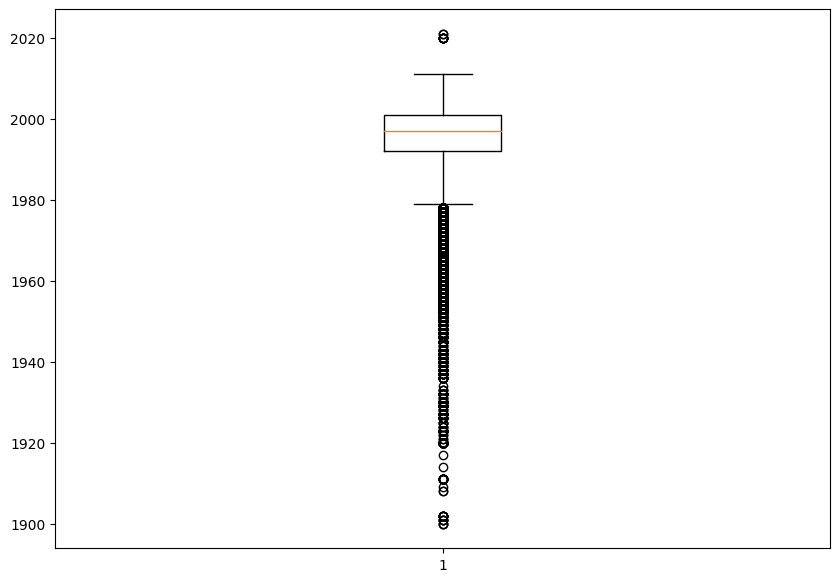

In [17]:
fig = plt.figure(figsize = (10, 7))
year = book['Year-Of-Publication']
plt.boxplot(year)
plt.show()

**Publisher Column**

The process involves the removal of leading and trailing whitespace, elimination of special characters, conversion of the initial letter to lowercase, and appropriate handling of non-string values.

In [18]:
book['Publisher'] = book['Publisher'].str.strip()
book['Publisher'] = book['Publisher'].str.replace('[^a-zA-Z\s]', '', regex=True)
book['Publisher'] = book['Publisher'].str.lower()
book['Publisher'].fillna("Unknown", inplace=True)
book = book.drop(book[book['Publisher'] == "Unknown"].index)

**Book Rating Column**

Due to ambiguity surrounding the interpretation of a 0 value within the rating column—whether it signifies a deliberate rating score or serves as a default placeholder for unrated entries—and considering the substantial bias towards this value within the dataset, a decision was made to eliminate rows where the rating value is zero.

In [19]:
book = book.drop(book[book['Book-Rating'] == 0].index)

**Location Column**

Excluding city and province to streamline the process and minimize unnecessary complexities.

In [20]:
book['Location'] = book['Location'].apply(lambda x:x.split(',')[-1])

**Age Column**

Filtering out age values that are invalid.

In [21]:
book = book.drop(book[(book['Age'] < 10) | (book['Age'] > 90)].index)

**Image-URL Column**

The removal of "Image-URL-S" and "Image-URL-L" columns has been initiated due to their deemed redundancy and lack of necessity within the dataset.

In [22]:
book = book.drop(['Image-URL-S', 'Image-URL-L'], axis=1)

**Mean Rating Column**

Calculating the mean rating scores corresponding to each ISBN.

In [23]:
book['Mean_Rating'] = book.groupby('ISBN')['Book-Rating'].transform('mean')

Storing the refined dataset within a distinct DataFrame and subsequently saving it as a CSV file.

In [ ]:
book.to_csv('/content/drive/MyDrive/DM Proj/clean_book.csv')

In [24]:
clean_book = pd.read_csv('/content/drive/MyDrive/DM Proj/clean_book.csv')

# Recommendation Model

In [25]:
sampled_data = clean_book.sample(n=5000, random_state=42)

In [26]:
sampled_data

,Unnamed: 0.1,Unnamed: 0,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M,User-ID,Book-Rating,Location,Age,ISBN_Length,Mean_Rating
151465,589443,589443,3442448867,raumschiff titanic,douglas adams,2001,goldmann,http://images.amazon.com/images/P/3442448867.0...,137766,3,germany,40.0,10,6.750000
2321,9119,9119,0786868716,the five people you meet in heaven,mitch albom,2003,hyperion,http://images.amazon.com/images/P/0786868716.0...,175832,10,usa,48.0,10,8.074257
255361,996582,996582,0345330137,double star,robert a heinlein,1986,del rey books,http://images.amazon.com/images/P/0345330137.0...,171118,8,canada,47.0,10,8.000000
217987,850590,850590,0952614715,and the truth shall set you free,david icke,1997,bridge of love publications,http://images.amazon.com/images/P/0952614715.0...,119663,7,usa,38.0,10,7.000000
69723,256561,256561,0679879242,the golden compass his dark materials book 1,philip pullman,1996,knopf books for young readers,http://images.amazon.com/images/P/0679879242.0...,270263,10,canada,62.0,10,8.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45444,164536,164536,0515119784,range of motion,elizabeth berg,1996,jove books,http://images.amazon.com/images/P/0515119784.0...,194600,8,canada,51.0,10,7.684211
143673,555612,555612,0803257414,on the border with crook,john bourke,1971,univ of nebraska pr,http://images.amazon.com/images/P/0803257414.0...,25601,8,usa,41.0,10,8.000000
701,3482,3482,0345417623,timeline,michael crichton,2000,ballantine books,http://images.amazon.com/images/P/0345417623.0...,1848,8,usa,22.0,10,7.783784
224413,874987,874987,0671570331,killers of man,ralph w cotton,1997,pocket,http://images.amazon.com/images/P/0671570331.0...,137968,5,usa,73.0,10,5.000000


Establishing a TfidfVectorizer object to transform the Author's names into a Tf-idf representation.

In [27]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(sampled_data['Book-Author'])
tfidf_matrix.shape

(5000, 3510)

Compute the cosine similarity matrix based on the authors' names and subsequently generate a DataFrame containing the calculated cosine similarity scores.

In [28]:
cosine_similarity = cosine_similarity(tfidf_matrix)
cosine_df = pd.DataFrame(cosine_similarity, index=sampled_data['Book-Title'], columns=sampled_data['Book-Title'])

Prompting the user to specify a book they prefer.
Retrieving the index of the specified book within the similarity dataframe.
Determine the top 5 most similar books based on the specified book.
Present the top 5 most similar books to the user's specified choice.

In [29]:
book_ = input('Write a book you like: ')
book_index = cosine_df.index.get_loc(book_)
recom = cosine_df.iloc[book_index].sort_values(ascending=False)[1:6]

print(f'Top 5 similar books to {book_}:')
print(recom)

Write a book you like: double star
Top 5 similar books to double star:
Book-Title
double star                                      1.000000
starship troopers                                1.000000
farnhams freehold                                1.000000
man who sold moon                                1.000000
vinas solamnus dragonlance lost legends vol 1    0.366115
Name: double star, dtype: float64


# Evaluation

Establishing the threshold for delineating similarity as either 1 or 0 and generating ground truth data based on threshold assumptions.

In essence, the ground truth data, derived from the cosine similarity results and established with a predefined threshold, forms the basis for evaluating how accurately the recommendation system identifies and recommends similar books.

In [30]:
threshold = 0.5
ground_truth = np.where(cosine_similarity >= threshold, 1, 0)

Transforming the cosine similarity matrix into a one-dimensional array to enable comparison. Converting the ground truth matrix into a similar one-dimensional format. Subsequently, computing the evaluation metrics.


- Precision value of 1.0 signifies that all the recommended books are relevant to the user's preferences.

- Recall value of 1.0 suggests that the system successfully identified and recommended all books relevant to the user.

- The F1-score value of 1.0 implies an ideal balance between precision and recall, highlighting the system's accuracy and completeness in recommending relevant books.

In [31]:
cosine_similarity_flat = cosine_similarity.flatten()
ground_truth_flat = ground_truth.flatten()

predictions = (cosine_similarity_flat >= threshold).astype(int)
precision, recall, f1, _ = precision_recall_fscore_support(
     ground_truth_flat, predictions, average='binary', zero_division=1
)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 1.0
Recall: 1.0
F1-score: 1.0


# Conclusion

The book recommendation system underwent a comprehensive journey, beginning with meticulous data cleaning and culminating in the implementation of a robust content-based filtering mechanism. The process commenced by refining and organizing the dataset, ensuring its integrity and coherence, laying a solid foundation for subsequent analysis. Leveraging content-based filtering, the system adeptly utilized book attributes and characteristics to generate recommendations, employing cosine similarity to quantify the likeness between books. Through the evaluation metrics of precision, recall, and F1-score, the system's performance was rigorously assessed. Impressively, the evaluation results unveiled an exemplary precision, recall, and F1-score of 1.0 each, demonstrating the system's exceptional accuracy in recommending books that align precisely with users' preferences.

This journey elucidates the system's evolution from data refinement to sophisticated recommendation generation, highlighting its proficiency in harnessing book attributes to derive insightful recommendations. The exceptional evaluation metrics underscore the system's capability to not only identify relevant books accurately but also to retrieve all pertinent items, showcasing a harmonious balance between precision and recall. As the system continues to evolve, these foundational strides in data refinement, content-based filtering, and rigorous evaluation serve as pillars for further enhancements, promising continued refinement and efficacy in delivering tailored book recommendations to users, setting a robust precedent for future advancements in personalized recommendation systems.

# References

Arashnic. (n.d.). Book Recommendation Dataset. Kaggle. Retrieved from https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset (Accessed: 16.10.2023)

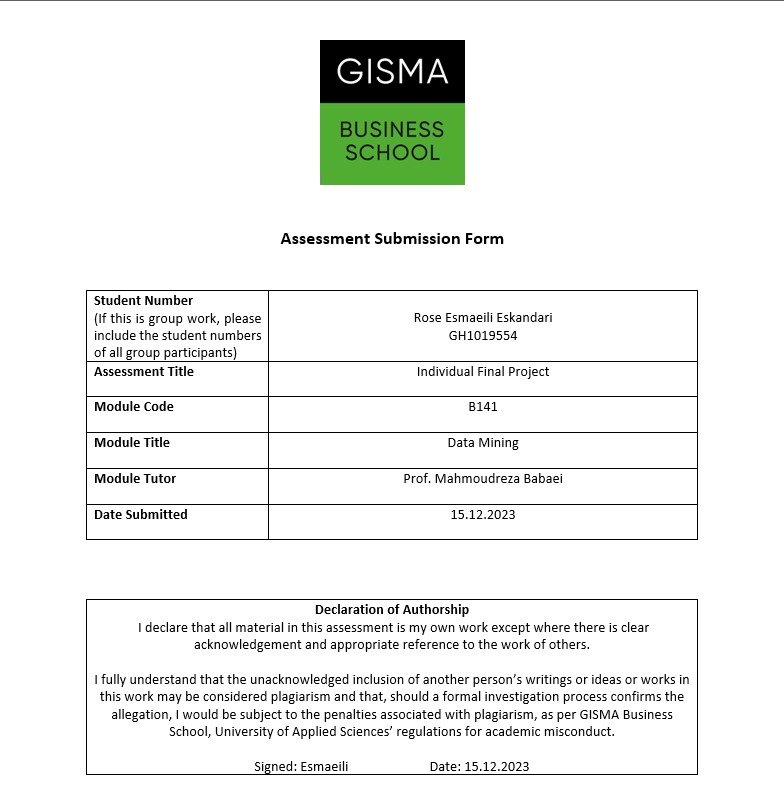